# Modify TextCNN from the workshop and train it on the IMDB dataset. 

Achieve 87% quality on the test sample. Let's define the test sample as follows:

```python
df = pd.read_csv('IMDB Dataset.csv')
df_train, df_test = np.split(df, [45000], axis=0)
```
So that we can check the assignment, submit your predictions for the test sample (classes, we consider positive = 0, negative = 1). To do this, use torch.save and submit a tensor of size (5000).

In [1]:
import torch
import torch.nn as nn
import numpy as np
import gensim.downloader as api
import pandas as pd


fasttext = api.load('glove-twitter-25')

[=======================================-----------] 78.5% 82.2/104.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 104.8/104.8MB downloaded


In [2]:
import re
import string
from collections import Counter


class Vocabulary:
    def __init__(self, texts: list[str], min_freq: int = 10):

        # getting string of text
        text = ' '.join(texts)

        # removing links, symbols and digits
        text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", text)
        text = re.sub("[^a-zA-Z]", " ", text)

        while '  ' in text:
            text = text.replace('  ', ' ')

        words = text.strip().lower().split()

        c = Counter(words)

        self.vocabulary = list(set([word for word in words if c[word] >= min_freq]))
        self.vocabulary.append('<unk>')
        self.vocabulary.append('<pad>')
        self._idx2word = {i: word for i, word in enumerate(self.vocabulary)}
        self._word2idx = {word: i for i, word in enumerate(self.vocabulary)}

    def get_vocabulary(self):
        return self.vocabulary

    def get_pad(self):
        return self.word2idx('<pad>')

    def idx2word(self, idx: int):
        if idx not in self._idx2word:
            return '<unk>'

        return self._idx2word[idx]

    def word2idx(self, word: str):
        word = word.lower()
        if word not in self._word2idx:
            return self._word2idx['<unk>']

        return self._word2idx[word]
    
    def encode(self, text):
        result = []

        for word in text.split():
            result.append(self.word2idx(word))

        return result

    def build_vectors(self, fasttext):
        vectors = []
        
        for word in self.vocabulary:
            if fasttext.has_index_for(word):
                vectors.append(fasttext[word])
            else:
                vectors.append(np.zeros(25))

        return np.stack(vectors)

In [3]:
from torch.utils.data import Dataset


class IMDB(Dataset):
    def __init__(self, df, vocab):
        self.df = df
        
        texts = self.df['review'].values

        self.vocab = vocab

        self.label2idx = {'positive': 0, 'negative': 1}

    def __getitem__(self, idx):
        text = self.df['review'].loc[idx]
        label = self.label2idx[self.df['sentiment'].loc[idx]]

        text = torch.LongTensor(self.vocab.encode(text))
        label = torch.FloatTensor([label])

        return text, label

    def __len__(self):
        return len(self.df)

In [4]:
df = pd.read_csv('/kaggle/input/imdb-dataset/IMDB Dataset.csv')

# common vocabulary
vocab = Vocabulary(df['review'].values, min_freq=5)

df_train, df_test = np.split(df, [45000], axis=0)

train_dataset = IMDB(df_train, vocab)
test_dataset = IMDB(df_test.reset_index(), vocab)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [5]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

pad_idx = vocab.get_pad()
# padding for correct, equal batch formation
def collate_fn(batch):
    
    texts = pad_sequence([b[0] for b in batch], padding_value=pad_idx, batch_first=True)
    labels = torch.stack([b[1] for b in batch])
    
    return texts, labels

train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=collate_fn, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn, pin_memory=True)

In [6]:
import torch.nn.functional as F


class TextCNN(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, pad_idx):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        self.convs = nn.ModuleList(
            [
                nn.Conv2d(
                    in_channels = 1, 
                    out_channels = 64, 
                    kernel_size = (fs, embedding_dim)) 
                for fs in [2, 3, 5, 7]
            ]
        )

        self.fc = nn.Linear(4 * 64, 1)

        self.dropout = nn.Dropout(0.3)
        self.dropout_2d = nn.Dropout2d(p=0.3)
        self.batch_norm = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)

        x = [F.relu(self.dropout_2d(self.batch_norm(conv(x)))).squeeze(3) for conv in self.convs]

        x = [F.max_pool1d(_, _.shape[2]).squeeze(2) for _ in x]

        x = self.dropout(torch.cat(x, dim = 1))

        return self.fc(x)

In [21]:
# creating model by 
model = TextCNN(vocab_size=len(vocab.vocabulary), embedding_dim=25, pad_idx=pad_idx)

# creating embedding vectors
vectors = vocab.build_vectors(fasttext)

#load pre-trained embedding vector values
model.embedding.weight.data[:len(vectors)] = torch.from_numpy(vectors)

In [19]:
from tqdm import tqdm


def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    acc = (rounded_preds == y).float().mean()
    return acc.item()


def train(model) -> float:
    model.train()

    train_loss = 0
    train_accuracy = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()
        train_accuracy += binary_accuracy(output, y)

        loss.backward()

        optimizer.step()

    train_loss /= len(train_loader)
    train_accuracy /= len(train_loader)

    return train_loss, train_accuracy


import torch


@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total_accuracy = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()
        total_accuracy += binary_accuracy(output, y)

    total_loss /= len(loader)
    total_accuracy /= len(loader)

    return total_loss, total_accuracy


import matplotlib.pyplot as plt
from IPython.display import clear_output


def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()


def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, test_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

    print(valid_accuracy_history)

In [22]:
model.embedding.weight.shape

torch.Size([39274, 25])

In [23]:
model.embedding.weight

Parameter containing:
tensor([[-1.3693, -1.2796, -0.2425,  ...,  0.2439, -0.1874, -0.2729],
        [-0.6666, -0.3537,  0.8957,  ..., -0.7859, -0.9200, -0.4770],
        [-0.4871,  0.8701, -0.1693,  ..., -0.6043, -0.4003,  0.0341],
        ...,
        [-0.1937, -0.7979,  0.4196,  ..., -0.7560, -0.1317, -1.6332],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       requires_grad=True)

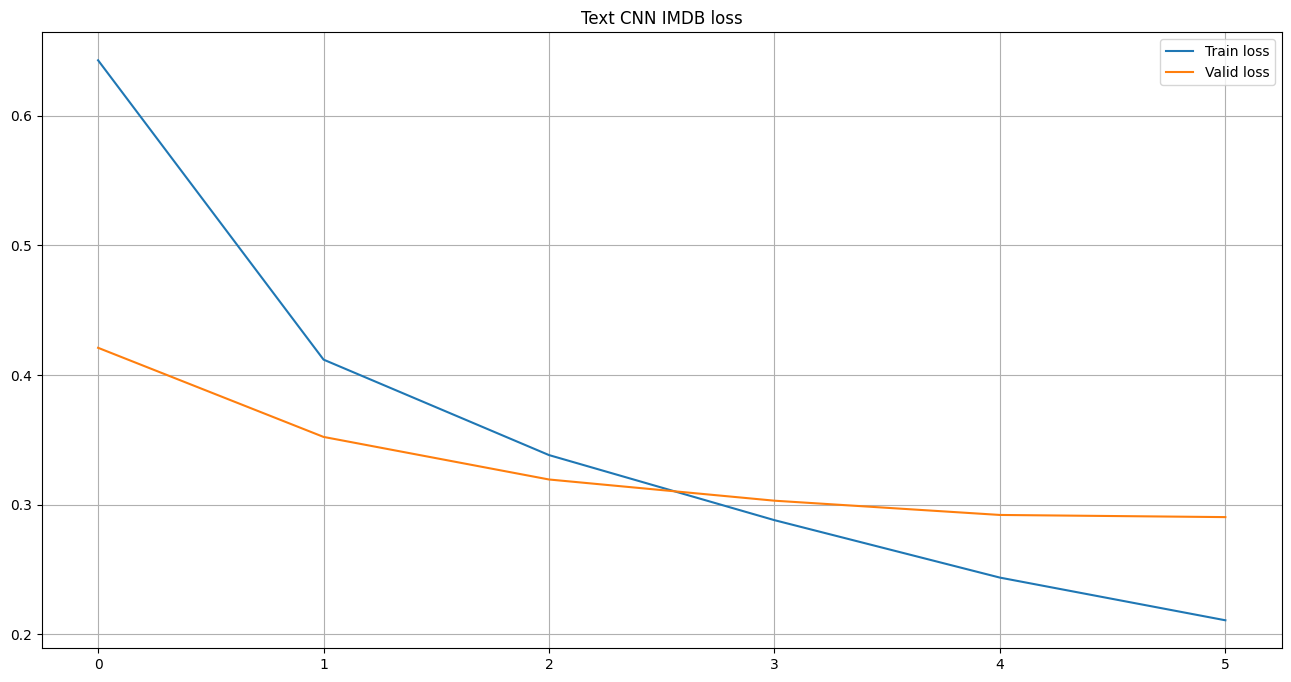

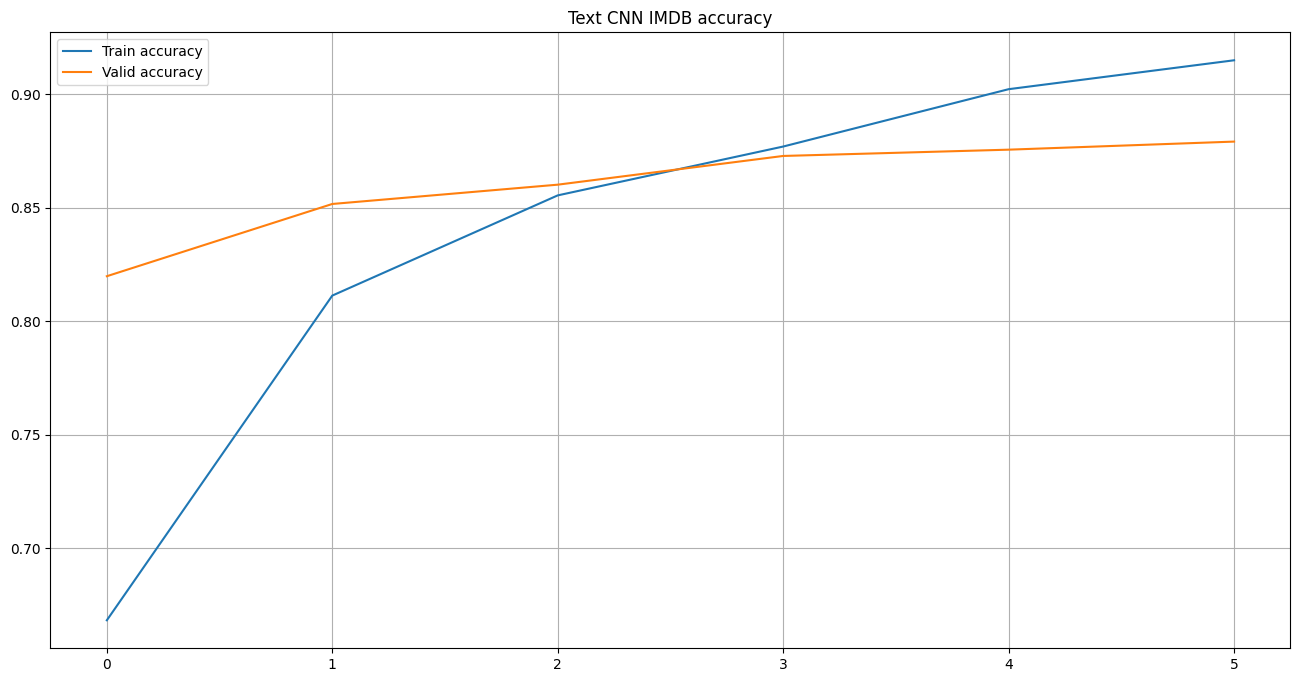

[0.8198180379746836, 0.8516613924050633, 0.8601661392405063, 0.8728243670886076, 0.8755933544303798, 0.8791534810126582]


In [24]:
import torch.nn as nn
from torch.optim import Adam

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

loss_fn = nn.BCEWithLogitsLoss()

model = model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

whole_train_valid_cycle(model, 6, 'Text CNN IMDB')



In [25]:
@torch.inference_mode()
def predict(model: nn.Module, loader: DataLoader, device: torch.device):
    
    model.eval()
    
    predicts =[]
    
    for x, y in loader:
        
        x, y = x.to(device), y.to(device)

        output = model(x)
        
        y_pred = torch.round(torch.sigmoid(output))
        
        predicts.append(y_pred)

    return  torch.cat(predicts)

In [26]:
predictions = predict(model, test_loader, device)

In [27]:
torch.squeeze(predictions)

tensor([0., 0., 1.,  ..., 1., 1., 1.], device='cuda:0')

In [ ]:
torch.save(torch.squeeze(predictions), 'predictions.pt')